# Riley, Alex -- Homework 3

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.stats import poisson
plt.style.use('seaborn-whitegrid')

We are given the number of days a given number of deaths has occurred (see Table 13.2 on p 240 of Lange).

In [2]:
freq = np.array([162,267,271,185,111,61,27,8,3,1])
num = np.arange(freq.size)

## Problem 1

The single parameter Poisson distribution has a likelihood function
$$ f(x_1,...,x_9 | \lambda) = \prod_{i=0}^9 \left[ \frac{e^{-\lambda}\lambda^i}{i!} \right]^{n_i}  $$

The log-likelihood is
$$ \log f = -\lambda\sum n_i + \log\lambda\sum in_i - \log\left( \prod (i!)^{n_i} \right) $$

Computing the maximum likelihood,
$$ \frac{d\log f}{d\lambda} = -\sum n_i + \frac{\sum in_i}{\lambda} = 0 $$

yields the MLE for $\lambda$
$$ \hat{\lambda} = \frac{\sum in_i}{\sum n_i} $$

This makes sense, since the mean for a Poisson distribution is $\lambda$ and we derived the average of deaths weighted by days that number of deaths occur.

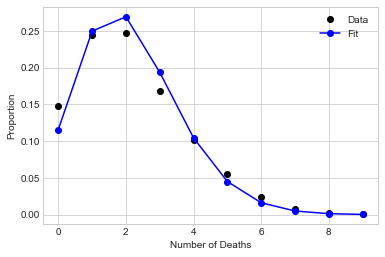

In [3]:
lambda_MLE = sum(num*freq)/sum(freq)
freq_MLE = poisson.pmf(num,lambda_MLE)

plt.plot(num, freq/np.sum(freq), 'o', color='black', label='Data')
plt.plot(num, freq_MLE, '-o', color='blue', label='Fit')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion")
plt.legend(loc='best');

## Problem 2

The likelihood function for the mixture of two Poissons model is
$$ f(\vec{\theta} | \alpha,\mu_1,\mu_2) = \prod_{i=0}^9 \left[ \alpha \frac{e^{-\mu_1}\mu_1^i}{i!} + (1-\alpha)\frac{e^{-\mu_2}\mu_2^i}{i!} \right]^{n_i} \equiv \prod_{i=0}^9 g_i^{n_i} $$

which means the log-likelihood is
$$ \log f = \sum_{i=0}^9 n_i \log g_i $$

To perform gradient ascent, we need to compute the derivatives:
$$ \begin{align}
\frac{\partial\log f}{\partial\alpha} &= \sum \frac{n_i}{g_i} \frac{\partial g_i}{\partial\alpha} = \sum \frac{n_i}{g_i} \left(\frac{e^{-\mu_1}\mu_1^i - e^{-\mu_2}\mu_2^i}{i!}\right) \\
\frac{\partial\log f}{\partial\mu_1} &= \sum \frac{n_i}{g_i} \frac{\partial g_i}{\partial\mu_1} = \sum \frac{n_i}{g_i}  \frac{\alpha e^{-\mu_1}}{i!} \left( -\mu_1^{i} + i\mu_1^{i-1} \right) \\
\frac{\partial\log f}{\partial\mu_2} &= \sum \frac{n_i}{g_i} \frac{\partial g_i}{\partial\mu_2} = \sum \frac{n_i}{g_i}  \frac{(1-\alpha)e^{-\mu_2}}{i!} \left(-\mu_2^{i} + i\mu_2^{i-1} \right)
\end{align} $$

In [4]:
def loglike(num,freq,p):
    a,mu1,mu2 = p
    return np.sum(freq*np.log(a*poisson.pmf(num,mu1)+(1-a)*poisson.pmf(num,mu2)))

def d_da(num,freq,p):
    a,mu1,mu2 = p
    return np.sum((freq*(poisson.pmf(num,mu1)-poisson.pmf(num,mu2)))/(a*poisson.pmf(num,mu1)+(1-a)*poisson.pmf(num,mu2)))

def d_dmu1(num,freq,p):
    a,mu1,mu2 = p
    return np.sum((a*freq*(-poisson.pmf(num,mu1)+poisson.pmf(num-1,mu1)))/(a*poisson.pmf(num,mu1)+(1-a)*poisson.pmf(num,mu2)))

def d_dmu2(num,freq,p):
    a,mu1,mu2 = p
    return np.sum(((1-a)*freq*(-poisson.pmf(num,mu2)+poisson.pmf(num-1,mu2)))/(a*poisson.pmf(num,mu1)+(1-a)*poisson.pmf(num,mu2)))

def grad(num,freq,p):
    return np.array([d_da(num,freq,p), d_dmu1(num,freq,p), d_dmu2(num,freq,p)])

and the updated values of parameters are simply
$$ \alpha,\mu_1,\mu_2 \leftarrow \alpha + \frac{\partial\log f}{\partial\alpha}, \mu_1 + \frac{\partial\log f}{\partial\mu_1}, \mu_2 \leftarrow \mu_2 + \frac{\partial\log f}{\partial\mu_2} $$

We employ gradient ascent with step-halving, adding in the numerical tolerance of 0.0001 (since 4 decimal places is good enough for us).

In [5]:
tol = 0.000001

p = [0.5,1.5,2.5]
while True:
    step = 0.01
    while loglike(num,freq,p+step*grad(num,freq,p)) < loglike(num,freq,p):
        step = step/2
    
    p1 = p+step*grad(num,freq,p)
    conv = p1 - p < tol
    
    if sum(conv)==3:
        break
    
    p = p1

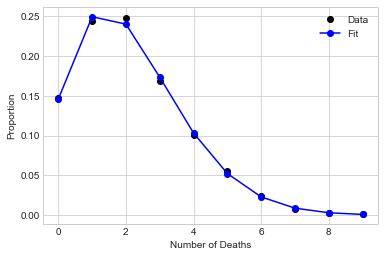

In [6]:
a,mu1,mu2 = p
freq_fit = a*poisson.pmf(num, mu1)+(1-a)*poisson.pmf(num, mu2)

plt.plot(num, freq/np.sum(freq), 'o', color='black', label='Data')
plt.plot(num, freq_fit, '-o', color='blue', label='Fit')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion")
plt.legend(loc='best');